# Horizontal integration on DLPFC using DIRAC

- by CHANG XU changxu@nus.edu.sg.
- Last update: October 4th 2024

## Download the data
- if you are have ``wget`` installed, you can run the following code to automatically download and unzip the data.

In [ ]:
# Skip this cells if data are already download
! wget -O 0725_Protein.h5ad "https://drive.google.com/uc?export=download&id=1en6bitR0ROS6eh-RgNJECErVVAzLMiok"
! wget -O 0725_RNA.h5ad "https://drive.google.com/uc?export=download&id=1uclBRs1I4Q1Yvq0eUfZbBwPiOVgFaKMt"

- if you do not have wget installed, manually download data from the links below:
    - DBiT-seq collected from ADT: https://drive.google.com/file/d/1en6bitR0ROS6eh-RgNJECErVVAzLMiok/view?usp=drive_link.
    - DBiT-seq collected from Protein: https://drive.google.com/file/d/1uclBRs1I4Q1Yvq0eUfZbBwPiOVgFaKMt/view?usp=drive_link.

## Run DIRAC on Dorsolateral Prefrontal Cortex (Spatial transcriptomics)
- Here, we are not using Jupyter for the demonstration, so it may take a bit longer. Of course, we will display the results after running.
- Here, we have demonstrated a downsampling of 8 samples as the source. If you want to test a different downsampling, simply set the sample_numbers to a number within 10.

In [ ]:
import torch
import numpy as np
from builtins import range
from torch_geometric.data import InMemoryDataset, Data
from sklearn.metrics import pairwise_distances
import sklearn.metrics
import pandas as pd
import anndata
import os 
import sys
import random
import matplotlib.pyplot as plt
import scanpy as sc

sys.path.append("/home/project/11003054/changxu/Projects/SpaGNNs/Section4/code/20240206V7")
from main import fit_semisupervised
from utils import get_single_edge_index, get_multi_edge_index, lsi
from pathlib import Path

def seed_torch(seed=1029):   
    random.seed(seed)    
    os.environ['PYTHONHASHSEED'] = str(seed)    
    np.random.seed(seed)    
    torch.manual_seed(seed)    
    torch.cuda.manual_seed(seed)    
    torch.cuda.manual_seed_all(seed) 
    # if you are using multi-GPU.    
    torch.backends.cudnn.benchmark = False    
    torch.backends.cudnn.deterministic = True

seed_torch(seed=6)

data_path = "/home/project/11003054/changxu/Data/Combine_brain"
data_path_raw = "/home/project/11003054/changxu/Data/DLPFC"
data_name = "DLPFC"
data_name_list = ['151507', '151508', '151509', '151510', '151669', '151670', 
                    '151671', '151672', '151673', '151674', '151675', '151676']
methods = "Dirac"

adata_raw = anndata.read_h5ad(os.path.join(data_path, f"{data_name}.h5ad"))
adata_raw.layers["counts"] = adata_raw.X.copy()
adata_raw.obsm['spatial'] = adata_raw.obsm['spatial'].astype('float32')
sc.pp.normalize_total(adata_raw)
sc.pp.log1p(adata_raw)
sc.pp.highly_variable_genes(
        adata_raw, 
        flavor="seurat_v3", 
        n_top_genes=5000, 
        layer="counts", 
        batch_key="batch",
    )
sc.pp.scale(adata_raw)
sc.tl.pca(adata_raw, n_comps=200)

save_path = os.path.join("/home/users/nus/changxu/scratch/Results", f"{data_name}_{methods}")
if not os.path.exists(save_path):
	os.makedirs(save_path)


colormaps= ["#8DD3C7", "#BEBADA", "#80B1D3", "#B3DE69", "#FCCDE5", 
"#BC80BD", "#FFED6F", "#8DA0CB", "#E78AC3", "#E5C494", "#CCCCCC", "#FB9A99"]
colormaps_clusters = dict(set(zip(adata_raw.obs["ground_truth"].unique(), colormaps)))
print(colormaps_clusters)
pairs = dict(set(zip(adata_raw.obs["class"], adata_raw.obs["ground_truth"])))
print(pairs)

data_name_list = ['151507', '151508', '151509', '151510', '151669', '151670', 
                    '151671', '151672', '151673', '151674', '151675', '151676']
sample_numbers = 8
restricted_list = ['151669', '151670', '151671', '151672']

df = pd.DataFrame(index=[n for n in adata_raw.obs["batch_name"].unique()], columns=[f"{methods}_ACC_{sample_numbers}", f"{methods}_Precision_{sample_numbers}",f"{methods}_Recall_{sample_numbers}",f"{methods}_F1_{sample_numbers}"])

for i in range(len(data_name_list)):
    test_adata = adata_raw[adata_raw.obs['batch_name'].isin([data_name_list[i]])]
    d_list = list(set(data_name_list)-{data_name_list[i]})
    while True:
        source_idx = random.sample(d_list, sample_numbers)
        restricted_count = sum([1 for s in source_idx if s in restricted_list])
        if restricted_count < sample_numbers:
            break 
    target_idx = list(set(d_list) - set(source_idx))
    source_adata = adata_raw[adata_raw.obs['batch_name'].isin(source_idx)]
    target_adata = adata_raw[adata_raw.obs['batch_name'].isin(target_idx)]
    source_edge_index = get_multi_edge_index(source_adata.obsm["spatial"].copy(), source_adata.obs["batch_name"], n_neighbors = 10)
    source_edge_index = torch.LongTensor(source_edge_index).T
    target_edge_index = get_multi_edge_index(target_adata.obsm["spatial"].copy(), target_adata.obs["batch_name"], n_neighbors = 10)
    target_edge_index = torch.LongTensor(target_edge_index).T  
    test_edge_index = get_single_edge_index(test_adata.obsm["spatial"].copy(), n_neighbors = 10)
    test_edge_index = torch.LongTensor(test_edge_index).T

    ####### 
    current_save_path = os.path.join(save_path,f"Downsample_{sample_numbers}", f"{data_name_list[i]}")
    if not os.path.exists(current_save_path):
    	os.makedirs(current_save_path)

    torch.cuda.empty_cache()
    semisuper = fit_semisupervised(save_path = current_save_path, use_gpu=True)
    samples = semisuper._get_data(
                source_data = source_adata.obsm["X_pca"].copy(),
                source_label = source_adata.obs['class'].values,
                source_edge_index = source_edge_index,
                target_data = target_adata.obsm["X_pca"].copy(),
                target_edge_index = target_edge_index,
                source_domain = np.zeros(source_adata.shape[0]),
                target_domain = np.ones(target_adata.shape[0]),
    			test_data = test_adata.obsm["X_pca"],
    			test_edge_index = test_edge_index,
                num_parts_source = source_adata.shape[0] // 300,
                num_parts_target = target_adata.shape[0] // 300,
                weighted_classes = False,)

    models = semisuper._get_model(samples=samples, opt_GNN = "SAGE")
    results = semisuper._train_GCAN(samples=samples, models=models, n_epochs=50)
    np.save(os.path.join(current_save_path, f"{data_name_list[i]}_{methods}_Results.npy"), results)
    source_adata.obsm[f"{methods}_embed"] = results["source_feat"]
    target_adata.obsm[f"{methods}_embed"] = results["target_feat"]
    test_adata.obsm[f"{methods}_embed"] = results["test_feat"]
    target_adata.obs[f"{methods}_pred"] = results["target_pred"]
    test_adata.obs[f"{methods}_pred"] = results["test_pred"]
    target_adata.obs[f"{methods}_pred_clusters"] = target_adata.obs[f"{methods}_pred"].map(pairs)
    test_adata.obs[f"{methods}_pred_clusters"] = test_adata.obs[f"{methods}_pred"].map(pairs)

    probabilities = pd.DataFrame(
        results['test_prob'],
        # columns=calib.classes_,
    )   
    probabilities.to_csv(os.path.join(current_save_path, f"{data_name_list[i]}_probabilities.csv"))
    pre = pd.DataFrame(np.vstack((test_adata.obs[f"{methods}_pred_clusters"], test_adata.obs[f"{methods}_pred"])).T, columns=["Preds_label", "Preds"],)
    truth = pd.DataFrame(np.vstack((test_adata.obs["ground_truth"].values, test_adata.obs["class"].values)).T, columns=["ground_truth_label", "ground_truth"],)
    pred_truth = pd.concat([pre, truth], axis=1)
    pred_truth.to_csv(os.path.join(current_save_path, f"{data_name_list[i]}_predictions.csv"))
    
    source_adata.write(os.path.join(current_save_path, f"{methods}_source.h5ad"), compression="gzip")
    target_adata.write(os.path.join(current_save_path, f"{methods}_target.h5ad"), compression="gzip")
    test_adata.write(os.path.join(current_save_path, f"{methods}_{data_name_list[i]}.h5ad"), compression="gzip")
    metrics_all = {
        "Accuracy Score":
            float(sklearn.metrics.accuracy_score(test_adata.obs['class'], test_adata.obs[f"{methods}_pred"])),
        "Precision Score":
            float(sklearn.metrics.precision_score(test_adata.obs['class'], test_adata.obs[f"{methods}_pred"], average='weighted')),
        "Recall Score":
            float(sklearn.metrics.recall_score(test_adata.obs['class'], test_adata.obs[f"{methods}_pred"], average='weighted')),
        "F1 Score":
            float(sklearn.metrics.f1_score(test_adata.obs['class'], test_adata.obs[f"{methods}_pred"], average='weighted'))}
    print(metrics_all)
    df.iloc[i,:] = np.array([metrics_all["Accuracy Score"],metrics_all["Precision Score"],metrics_all["Recall Score"],metrics_all["F1 Score"]])
    
    sc.pl.spatial(test_adata, color=['ground_truth', f'{methods}_pred_clusters'], palette=colormaps_clusters, frameon=False, spot_size=150, title=["Truth", f"ACC: {metrics_all['Accuracy Score']}"])
    plt.savefig(os.path.join(current_save_path, f"{data_name}_{methods}_{data_name_list[i]}.pdf"), bbox_inches='tight', dpi = 300)
        
df.to_csv(os.path.join(save_path, f"{data_name}_{sample_numbers}_metrics.csv"))

## Presentation of DIRAC results and comparison with other methods
- Display the spatial domain map;
- Show the ROC curve for the sample 151673 slice;
- Display the UMAP plot for 151673 as an independent test.

### Spatial domain presentation of DIRAC

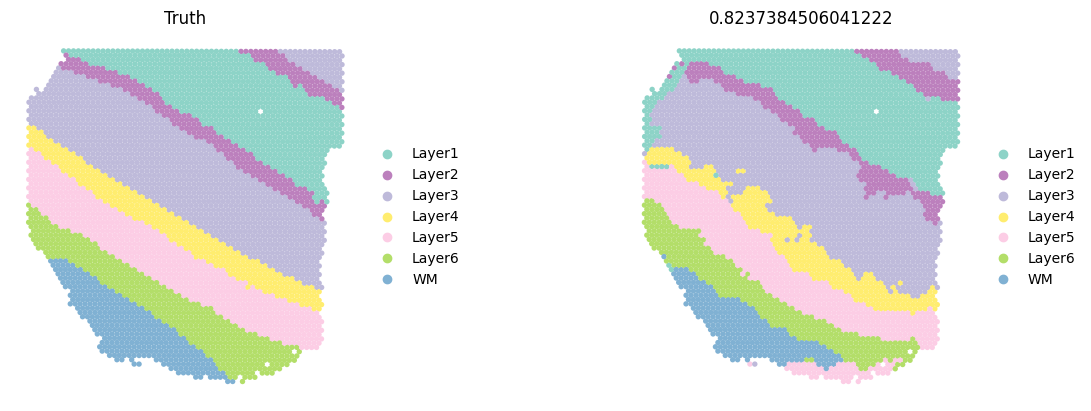

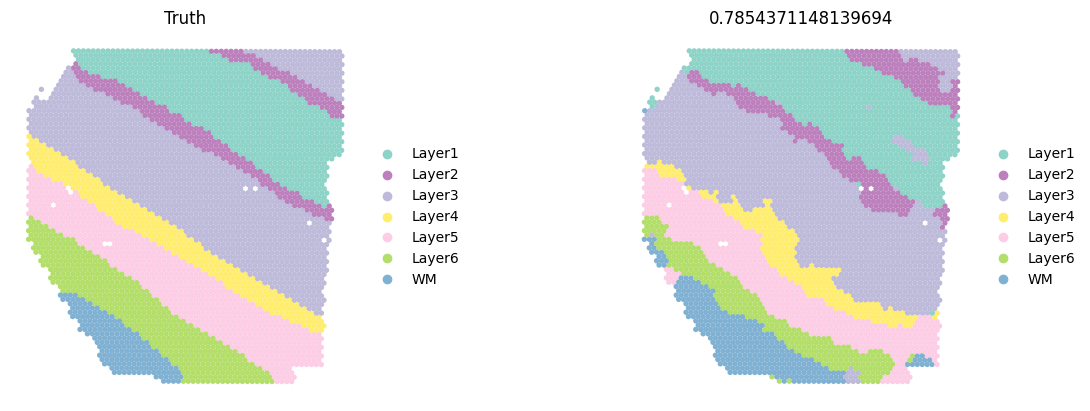

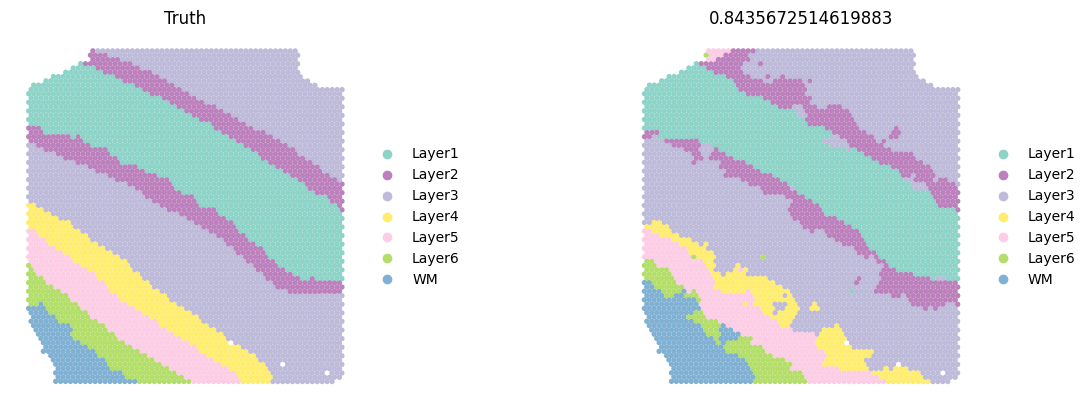

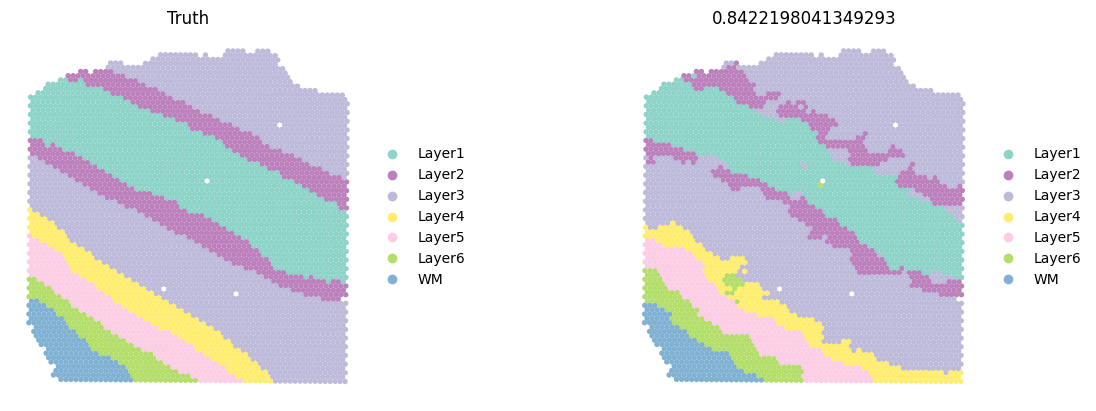

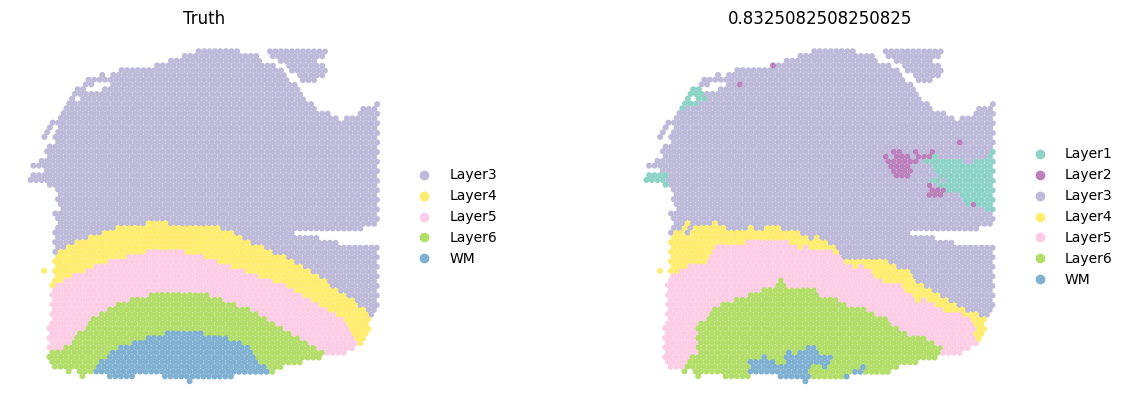

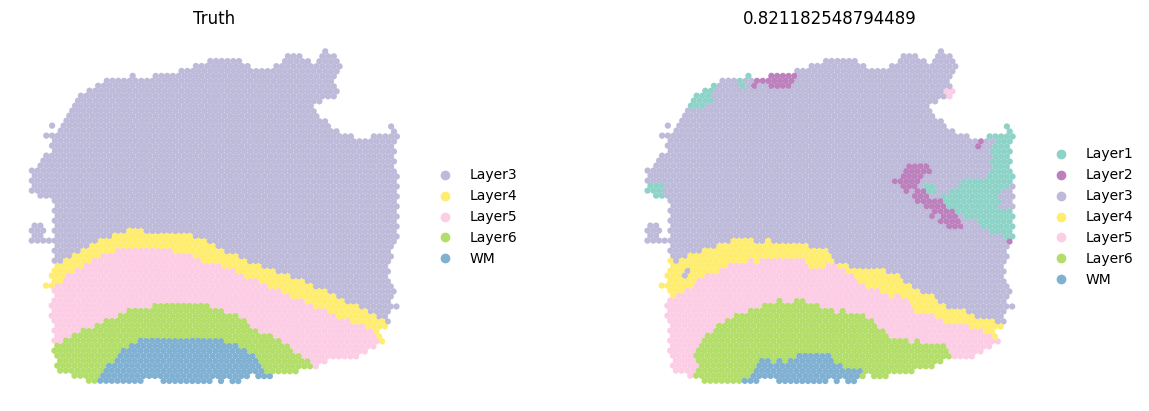

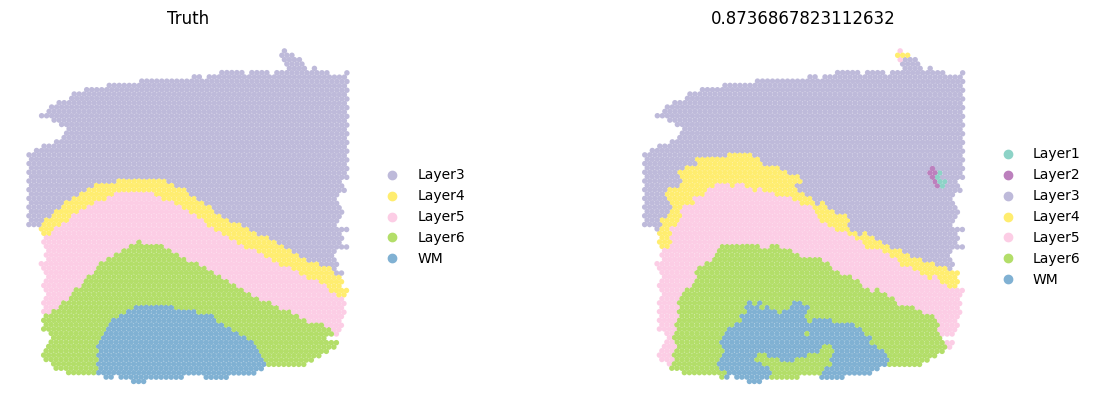

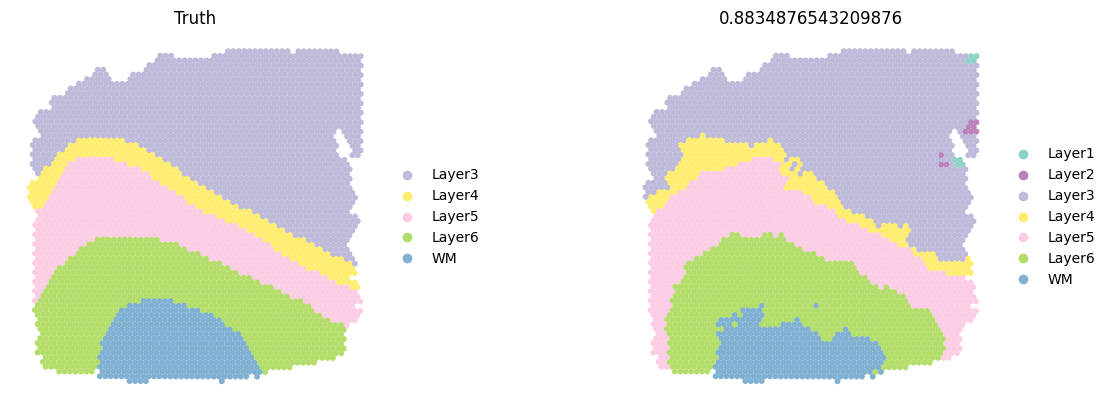

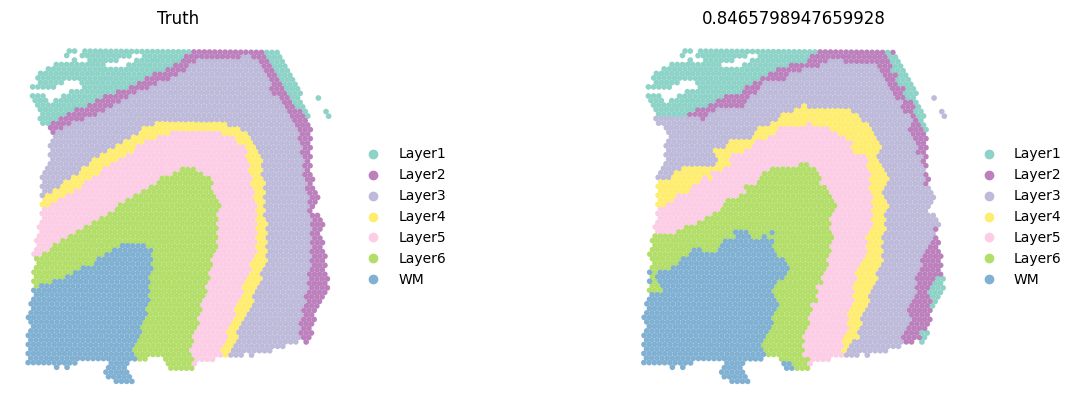

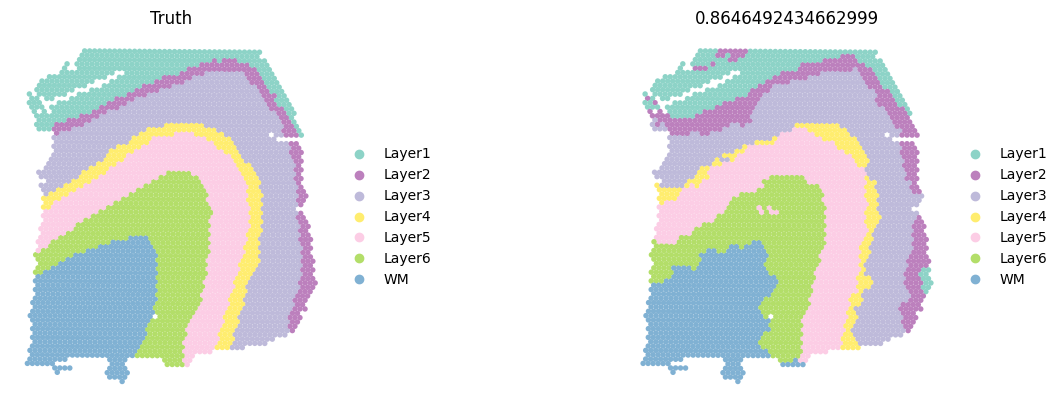

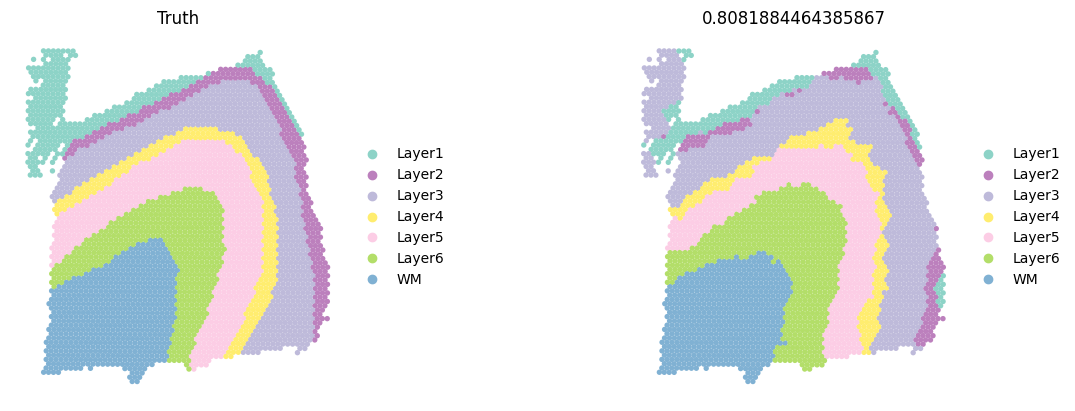

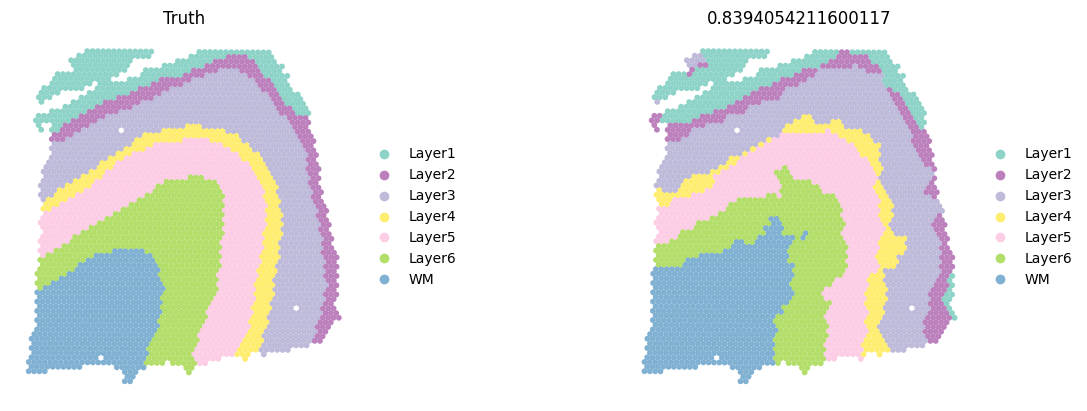

In [1]:
import os
import sklearn.metrics
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc
import anndata

data_path = "/home/project/11003054/changxu/Data/DLPFC"
data_name = "DLPFC"
data_name_list = ['151507', '151508', '151509', '151510', '151669', '151670', 
                    '151671', '151672', '151673', '151674', '151675', '151676']
methods = "Dirac"
save_path = os.path.join("/home/users/nus/changxu/scratch/Results", f"{data_name}_{methods}")

adata = anndata.read_h5ad(os.path.join("/home/project/11003054/changxu/Data/Combine_brain", "DLPFC.h5ad"))
colormaps= ["#8DD3C7", "#BEBADA", "#80B1D3", "#B3DE69", "#FCCDE5", 
"#BC80BD", "#FFED6F", "#8DA0CB", "#E78AC3", "#E5C494", "#CCCCCC", "#FB9A99"]
colormaps_clusters = dict(set(zip(adata.obs["ground_truth"].unique(), colormaps)))

sample_numbers = 8
for i in range(len(data_name_list)):
    current_save_path = os.path.join(save_path, f"Downsample_{sample_numbers}", f"{data_name_list[i]}")
    current_adata = sc.read(os.path.join(current_save_path, f"{methods}_{data_name_list[i]}.h5ad"))
    ACC = float(sklearn.metrics.accuracy_score(current_adata.obs['class'], current_adata.obs[f"{methods}_pred"]))
    sc.pl.spatial(current_adata, color=['ground_truth', f'{methods}_pred_clusters'], palette=colormaps_clusters, 
                  frameon=False, spot_size=150, 
                  title=["Truth",f"{ACC}"]) 

### Compare the ACC pirate plots of all methods
- Here, R package "yarrr" needs to be loaded

In [2]:
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)

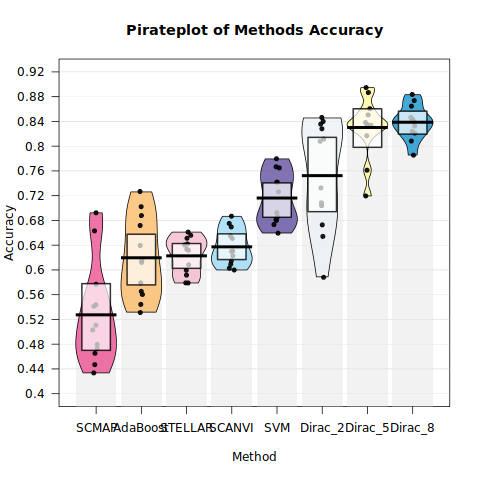

In [3]:
%%R
.libPaths("/home/project/11003054/e1124313/env/go/lib/R/library")
library(ggplot2)
library(yarrr)

# Read the data from the CSV file
mydata <- read.table("/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/DLPFC/All_methods_acc.csv", header=TRUE, sep=',')

# Define custom color mapping for different methods
methods_colors <- c(
    "SVM" = "#EB5291FF",
    "SCANVI" = "#FBBB68FF",
    "AdaBoost" = "#F5BACFFF",
    "SCMAP" = "#9DDAF5FF",
    "STELLAR" = "#6351A0FF",
    "Dirac_2" = "#ECF1F4FF",
    "Dirac_5" = "#FEF79EFF",
    "Dirac_8" = "#1794CEFF"
)

# Convert the Method column to a factor to ensure order matches the color mapping
mydata$Method <- factor(mydata$Method, levels = names(methods_colors))

# Save the plot as a PDF (commented out)
# pdf("/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/DLPFC/pirateplot_chicken_weights.pdf", width = 8, height = 6)

# Create the pirate plot using the specified settings
pirateplot(formula = Accuracy ~ Method,
           data = mydata,
           theme = 1,  # Set plot theme
           main = "Pirateplot of Methods Accuracy",  # Main title
           pal = methods_colors,  # Use the color mapping defined above
           bean.f.o = .8,  # Bean fill opacity
           point.o = .9,   # Points opacity
           inf.f.o = .7,   # Inference fill opacity
           inf.b.o = .8,   # Inference border opacity
           avg.line.o = 1,  # Average line opacity
           bar.f.o = .5,    # Bar opacity
           inf.f.col = "white",  # Inference fill color
           inf.b.col = "black",  # Inference border color
           avg.line.col = "black",  # Average line color
           bar.f.col = gray(.9),  # Bar fill color
           point.pch = 21,   # Point shape
           point.bg = "black",  # Point background color
           point.col = "black",  # Point border color
           point.cex = .8,    # Point size
           cap.beans = TRUE,  # Cap the beans
           sortx = "mean")    # Sort the methods by mean accuracy

# Close the PDF device (commented out)
# dev.off()


### Draw ROC curve

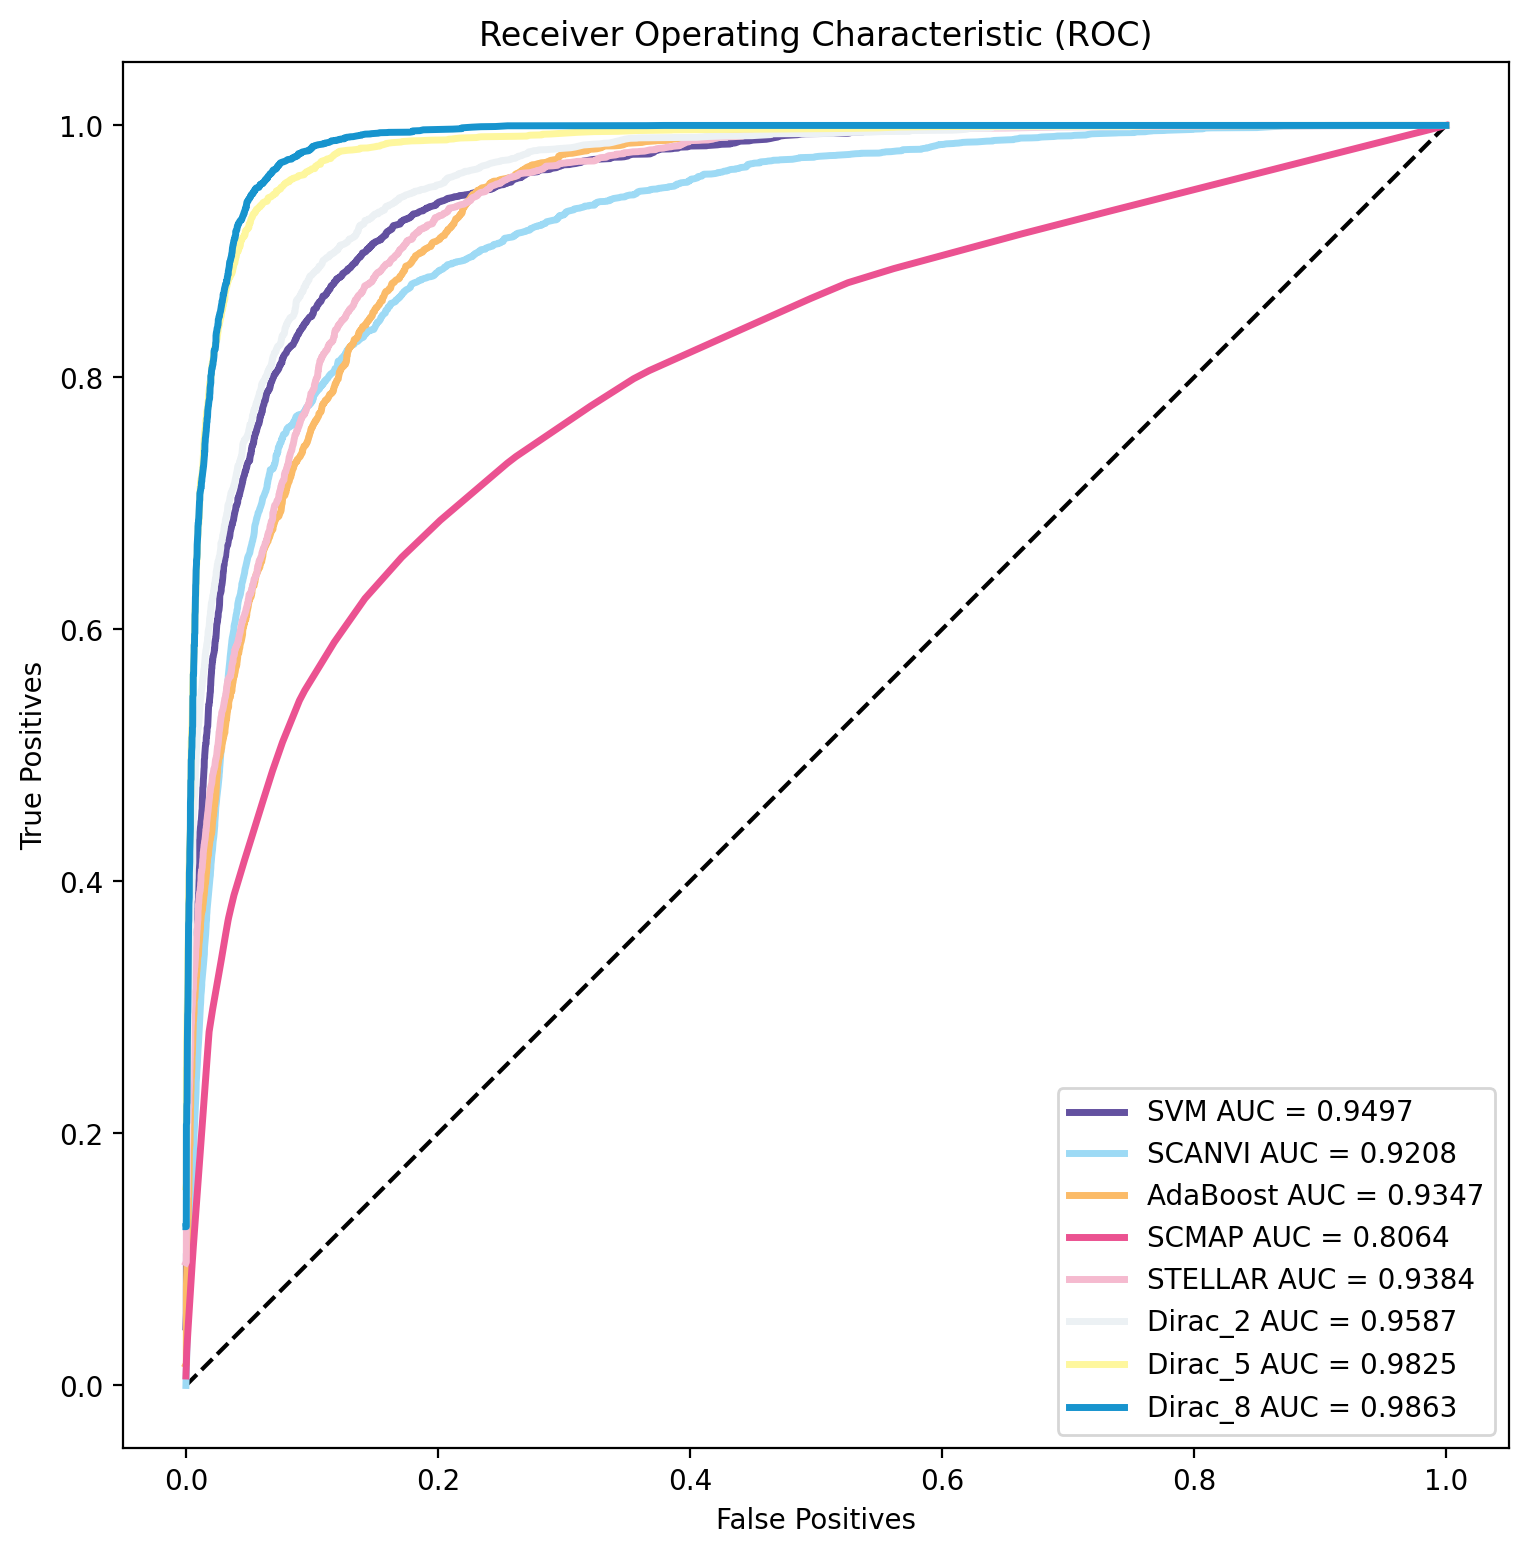

In [4]:
import os
import sklearn.metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

data_path = "/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/DLPFC"
methods_list = [
    'SVM',
    'SCANVI',
    'AdaBoost',
    'SCMAP',
    'STELLAR',
    'Dirac_2',
    'Dirac_5',
    'Dirac_8',
]
# data_name_list = ['151507', '151508', '151509', '151510', '151669', '151670', 
#                   '151671', '151672', '151673', '151674', '151675', '151676']

data_name_list = ['151673']

# Plot ROC curve
## One-hot encode data classes
fpr_methods = dict()
tpr_methods = dict()
roc_auc_methods = dict()

for methods in methods_list:
    for data_name in data_name_list:
        # Read predictions and probabilities for each method and data slice
        df_preds = pd.read_csv(os.path.join(data_path, f"DLPFC_{methods}", data_name, f"{data_name}_predictions.csv"))
        df_outputs = pd.read_csv(os.path.join(data_path, f"DLPFC_{methods}", data_name, f"{data_name}_probabilities.csv"))
        del df_outputs["Unnamed: 0"]
        
        if methods == "Dirac":
            df_preds = df_preds.dropna()  # Drop missing values for Dirac method
            
        # Set number of classes based on data name
        if data_name in ['151669', '151670', '151671', '151672']:
            n_classes = 5
        else:
            n_classes = 7
            
        labels_list = df_preds["ground_truth"]
        preds_list = df_preds["Preds"]
        
        # One-hot encoding for labels
        onehot = np.zeros((labels_list.size, preds_list.max() + 1))
        onehot[np.arange(labels_list.size), labels_list] = 1
        onehot = onehot.astype('int')
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(onehot[:, i], df_outputs.values[:, i])
            roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
        
        ## Get macro-average AUROC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        
        fpr_methods[f"{methods}_{data_name}_macro"] = all_fpr
        tpr_methods[f"{methods}_{data_name}_macro"] = mean_tpr
        roc_auc_methods[f"{methods}_{data_name}_macro"] = sklearn.metrics.auc(fpr_methods[f"{methods}_{data_name}_macro"], tpr_methods[f"{methods}_{data_name}_macro"])

# Define the colors for each method
colors_list = {
    "SCMAP": "#EB5291FF",
    "AdaBoost": "#FBBB68FF",
    "STELLAR": "#F5BACFFF",
    "SCANVI": "#9DDAF5FF",
    "SVM": "#6351A0FF",
    "Dirac_2": "#ECF1F4FF",
    "Dirac_5": "#FEF79EFF",
    "Dirac_8": "#1794CEFF"
}

# Plot ROC for each data slice
for data_name in data_name_list:
    plt.figure(figsize=(9, 9), dpi=200)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Plot diagonal line
    
    for methods in methods_list:
        # Plot ROC curves for each method
        roc_values = roc_auc_methods[f"{methods}_{data_name}_macro"]
        color = colors_list[methods]  # Use method name as color key
        plt.plot(fpr_methods[f"{methods}_{data_name}_macro"], 
                 tpr_methods[f"{methods}_{data_name}_macro"], 
                 label=f"{methods} AUC = {roc_values:.4f}", 
                 linewidth=2.5, color=color)
    
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.xlabel('False Positives')
    plt.ylabel('True Positives')
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc='lower right')
    
    # Create save path
    save_data_path = Path(os.path.join(data_path, "ROC"))
    save_data_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(os.path.join(save_data_path, f"{data_name}_ROC.pdf"), dpi=300)
    plt.show()  # Show the plot, comment this line if not needed


### Show UMAP on 151673 as test data

computing neighbors


/home/users/nus/changxu/Software/anaconda3/envs/SpaGNNs_gpu/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/users/nus/changxu/Software/anaconda3/envs/SpaGNNs_gpu/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/users/nus/changx

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:44)


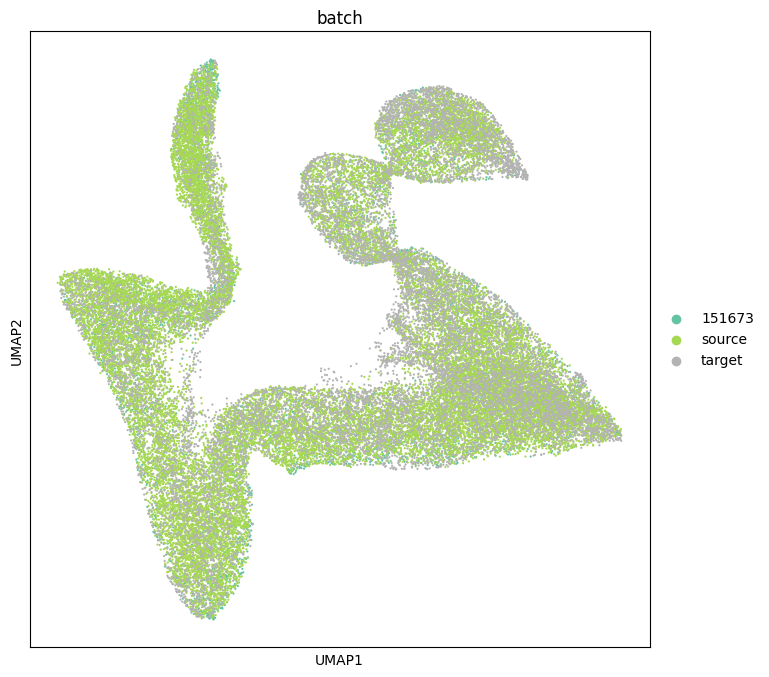

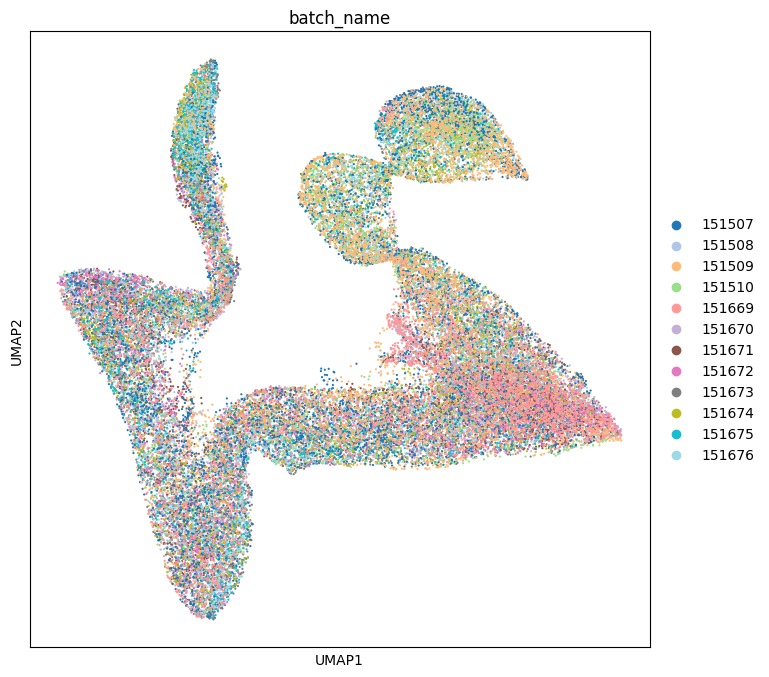

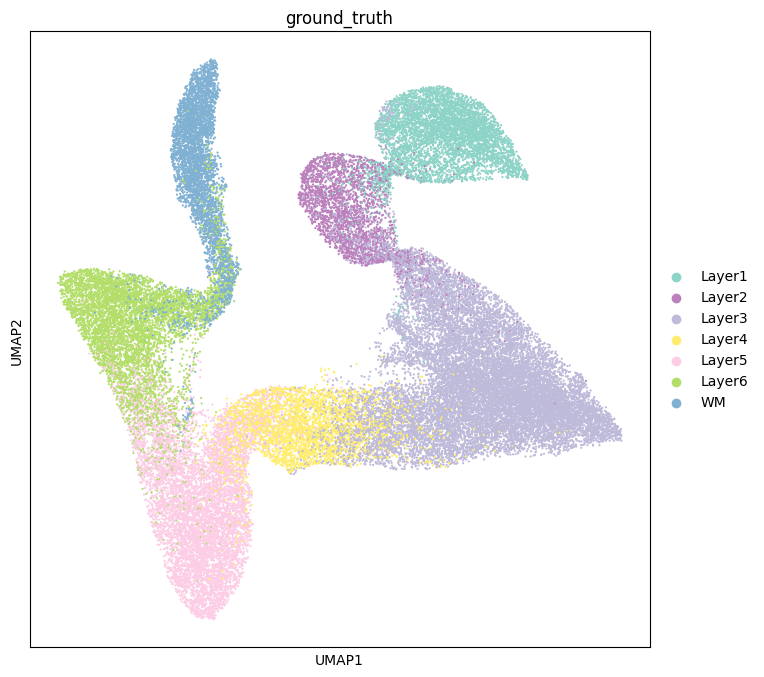

In [5]:
# Define the data path
data_path = "/home/users/nus/changxu/scratch/Results/DLPFC_Dirac_8/151673"

# Load different datasets
adata_151673 = sc.read(os.path.join(data_path, "Dirac_151673.h5ad"))
adata_source = sc.read(os.path.join(data_path, "Dirac_source.h5ad"))
adata_target = sc.read(os.path.join(data_path, "Dirac_target.h5ad"))

# Concatenate the datasets, labeling them by batch for distinction
adata = anndata.concat([adata_151673, adata_source, adata_target], 
                       label='batch',  # Label to distinguish between different datasets
                       keys=['151673', 'source', 'target'])

######### Plot UMAP
# Define color mappings for different layers (ground truth labels)
colormaps = {'Layer4': '#FFED6F', 'Layer1': '#8DD3C7', 'Layer6': '#B3DE69', 
             'Layer2': '#BC80BD', 'Layer3': '#BEBADA', 'Layer5': '#FCCDE5', 
             'WM': '#80B1D3'}

# Compute nearest neighbors using the 'Dirac_embed' representation
sc.pp.neighbors(adata, use_rep='Dirac_embed', n_neighbors=30)

# Perform UMAP dimensionality reduction
sc.tl.umap(adata)

# Plot UMAP with 'batch' as the color, indicating the batch origin of each cell
sc.pl.umap(adata, color=['batch'], size=10, palette="Set2")

# Plot UMAP with 'batch_name' as the color (another categorical variable)
sc.pl.umap(adata, color=['batch_name'], size=10, palette="tab20")

# Plot UMAP with 'ground_truth' labels, using predefined colormaps for layers
sc.pl.umap(adata, color=["ground_truth"], palette=colormaps, size=10)
